In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import sklearn.linear_model
π = np.pi

In [6]:
url = 'https://www.cl.cam.ac.uk/teaching/2223/DataSci/data/climate.csv'
#climate = pandas.read_csv(url)
# Or run the scraping code at the bottom
# (Warning: the scraping code may break if the Met Office changes its webpages. If it breaks,
# just use the csv above.)

# Define two extra covariates
climate['t'] = climate.yyyy + (climate.mm-1)/12    # timestamp in years
climate['temp'] = (climate.tmin + climate.tmax)/2  # monthly avg temp

In [11]:
# Restrict attention to Cambridge, 1985 onwards, for illustration
df = climate.loc[(climate.station=='Cambridge') & (climate.yyyy>=1985)]

X = np.column_stack([np.sin(2*π*df.t), np.cos(2*π*df.t)])
model = sklearn.linear_model.LinearRegression()
model.fit(X, df.temp)
α,(β1,β2) = (model.intercept_, model.coef_)

print((model.intercept_, model.coef_))
# Plot a curve to depict the fitted values
tnew = np.linspace(1985, 2024, 1000)
Xnew = np.column_stack([np.sin(2*π*tnew), np.cos(2*π*tnew)])
temp_pred = model.predict(Xnew)

fig,ax = plt.subplots(figsize=(15,1.7))
ax.scatter(df.t, df.temp, s=15, alpha=0.7)
ax.plot(tnew, temp_pred, color='0.7', zorder=0)
ax.set_xlim([1984,2025])
ax.set_ylim([-3,23])
ax.set_title('Monthly average temperature [°C]')

plt.show()

ValueError: operands could not be broadcast together with shapes (454,) (454,2) 

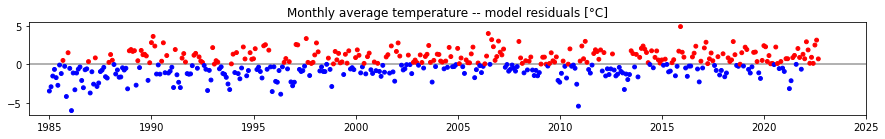

In [9]:
resid = df.temp - model.predict(X)

fig,ax = plt.subplots(figsize=(15,1.7))
ax.scatter(df.t, resid, c=np.where(resid<=0,'blue','red'), s=15)
ax.axhline(0, color='0.6', zorder=0)
ax.set_xlim([1984,2025])
ax.set_title('Monthly average temperature -- model residuals [°C]')
plt.show()

What is the rate of temperature increase in Cambridge?

10.514034451752183
-1.107716558433125 -6.560983691731712 0.035071793932324624
1.4617004004521668


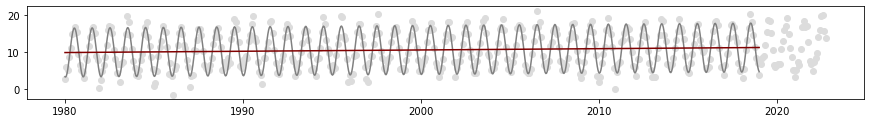

In [20]:
df1 = climate.loc[(climate.station == 'Cambridge') & (climate.yyyy>=1980)]
def temp_inc(t, temp):
    model = sklearn.linear_model.LinearRegression()
    model.fit(np.column_stack([np.sin(2*π*t), np.cos(2*π*t), t-2000]), temp)
    return model

model2 = temp_inc(df1.t, df1.temp)

intercept = model2.intercept_
alpha, beta, gamma = model2.coef_
print(intercept)
print(alpha, beta, gamma)

print(np.sqrt(np.sum(np.square(df.temp - (intercept + alpha*np.sin(2*π*df.t) + beta*np.cos(2*π*df.t) + gamma*(df.t-2000)))))/(np.sqrt(len(X))))

fig, ax = plt.subplots(figsize=(15,1.7))
ax.scatter(df1.t, df1.temp, color='gainsboro')
x1 = np.linspace(1980, 2019, 1000)
ax.plot(x1, model2.predict(np.column_stack([np.sin(2*π*x1), np.cos(2*π*x1), (x1-2000)])), color='gray')
ax.plot(x1, (x1-2000)*gamma + model2.intercept_, color='maroon')
plt.show()

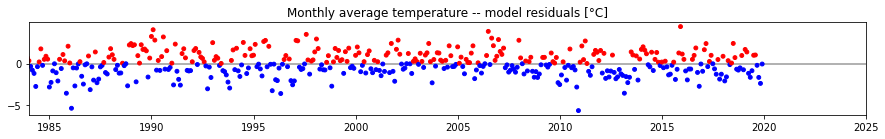

In [236]:
resid = df1.temp - model.predict(np.column_stack([np.sin(2*π*df1.t), np.cos(2*π*df1.t), df1.t]))

fig,ax = plt.subplots(figsize=(15,1.7))
ax.scatter(df1.t, resid, c=np.where(resid<=0,'blue','red'), s=15)
ax.axhline(0, color='0.6', zorder=0)
ax.set_xlim([1984,2025])
ax.set_title('Monthly average temperature -- model residuals [°C]')
plt.show()

# Are temperatures increasing at a constant rate, or has the increase accelerated?

0.07007245505920937 0.059447005706107406 -0.00688726321833507 0.031786422719650036


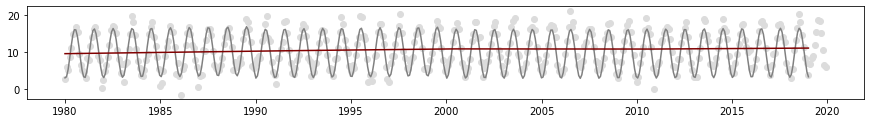

In [259]:
df2 = climate.loc[(climate.station == 'Cambridge') & (climate.yyyy>=1980) & (climate.yyyy<=2019)]
decades = np.unique(df2['yyyy'].apply(lambda x: ((x//10) * 10)))
decades_onehot = [np.where(df2['yyyy'].apply(lambda x: math.floor(x/10) == decade/10),1,0) for decade in decades]

model = sklearn.linear_model.LinearRegression()
secular = [abs((df2.t - decades[i])*decades_onehot[i]) + np.sum([10*d for d in decades_onehot[i+1:]], 0) for (i, decade) in enumerate(decades)]
divine = [np.sin(2*π*df2.t), np.cos(2*π*df2.t)]
model.fit(np.column_stack(secular + divine), df2.temp)
alpha, (beta, gamma, delta, epsilon, s, c) = model.intercept_, model.coef_

x2 = np.linspace(1980, 2019, 480)
new_onehot = [np.where(np.floor(x2/10) == decade/10,1,0) for decade in decades]
new_features = [(x2 - np.floor(x2/10)*10)*oh for oh in new_onehot]
print(beta, gamma, delta, epsilon)
    
def line(x):
    if x < 1990:
        return alpha + beta*(x-1980)
    elif x < 2000: 
        return alpha + beta*10 + gamma*(x-1990)
    elif x < 2010:
        return alpha + beta*10 + gamma*10 + delta*(x-2000)
    else:
        return alpha + beta*10 + gamma*10 + delta*10 + epsilon*(x-2010)
fig, ax = plt.subplots(figsize=(15,1.7))
ax.scatter(df1.t, df1.temp, color='gainsboro')
ax.plot(x2, model.predict(np.column_stack(new_features + [np.sin(2*π*x2), np.cos(2*π*x2)])), color='gray')
ax.plot(x2, np.vectorize(line)(x2), color='maroon')

plt.show()

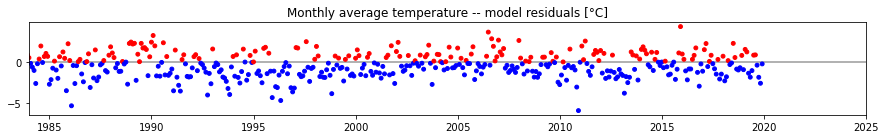

In [260]:
test_onehot = [np.where(np.floor(df2.t/10) == decade/10,1,0) for decade in decades]
test = [(df2.t - np.floor(df2.t/10)*10)*oh + np.sum([10*d for d in test_onehot[i+1:]], 0) for oh in test_onehot]
resid = df2.temp - model.predict(np.column_stack(test + [np.sin(2*π*df2.t), np.cos(2*π*df2.t)]))

fig,ax = plt.subplots(figsize=(15,1.7))
ax.scatter(df2.t, resid, c=np.where(resid<=0,'blue','red'), s=15)
ax.axhline(0, color='0.6', zorder=0)
ax.set_xlim([1984,2025])
ax.set_title('Monthly average temperature -- model residuals [°C]')
plt.show()

How do results compare across the whole of the UK?

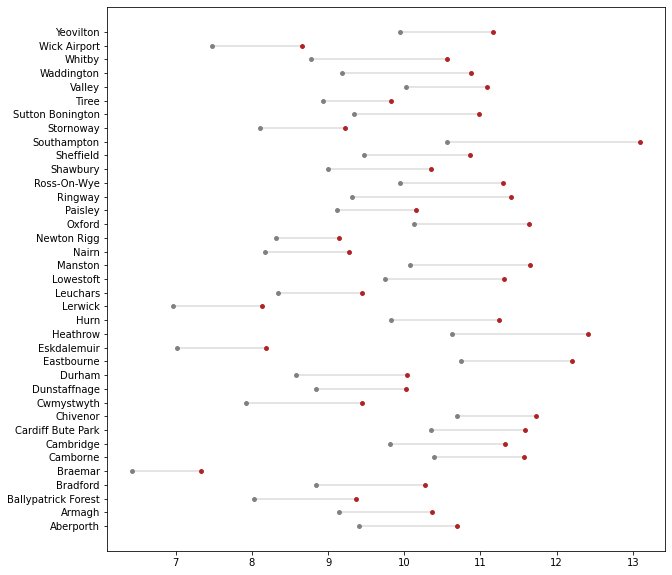

In [361]:
df3 = climate.loc[(climate.yyyy>=1980) & (climate.yyyy<=2022) & (np.isfinite(climate.temp))]

stations = np.unique(df3['station'])
stations_onehot = [np.where(df3['station'] == station ,1,0) for station in stations]

model3 = sklearn.linear_model.LinearRegression(fit_intercept=False)
secular = stations_onehot + [indicator*(df3.t - 1980) for indicator in stations_onehot]
divine = [np.sin(2*π*(df3.t - 1980)), np.cos(2*π*(df3.t - 1980))]
model3.fit(np.column_stack(secular+divine), df3.temp)

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(model3.coef_[:len(stations)], stations, color='0.5', s=15)
ax.scatter(model3.coef_[:len(stations)]+ model3.coef_[len(stations):2*len(stations)]*43, stations, color='firebrick', s=15)

results = list(zip(stations, model3.coef_[:len(stations)], model3.coef_[len(stations):2*len(stations)]))
for i in range(len(stations)):
    plt.plot([model3.coef_[i], model3.coef_[i]+ (model3.coef_[len(stations)+i] * 43)], [stations[i], stations[i]], color='gainsboro', zorder=0)
plt.show()

[-5.28017058e-03 -7.05652903e-03 -4.31787923e-03 -2.03224196e-03
 -1.44109286e-02 -7.76546181e-03 -6.74752756e-03 -1.10250582e-02
 -1.26069403e-05 -7.72994851e-03 -1.31312291e-03 -1.37952036e-03
 -8.20704485e-03  6.21608130e-03 -2.14781086e-03 -8.13536760e-03
 -9.75071891e-03  1.23183418e-03  1.47604892e-03 -9.53071029e-03
 -1.60368242e-02 -3.97851389e-04 -1.12116228e-02  1.32531623e-02
 -3.89366382e-03 -3.85974512e-03 -2.85738361e-03  2.34702173e-02
 -9.36908023e-03  2.85439706e-03 -1.47776192e-02 -1.06057794e-02
  4.07840339e-03  6.31412708e-03 -7.90006388e-03 -6.88938878e-03
  3.52840808e-02 -1.04612289e+00 -5.66961851e+00]
36
36


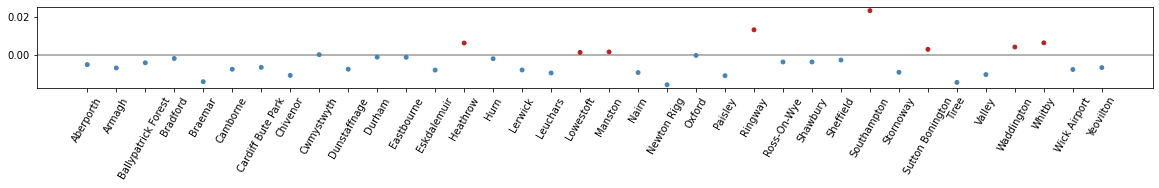

In [352]:
df4 = climate.loc[(climate.yyyy>=1980) & (np.isfinite(climate.temp))]

stations = np.unique(df4['station'])
stations = np.delete(stations, np.where(stations == 'Cambridge'), axis=0)
stations_onehot = [np.where(df4['station'] == station ,1,0) for station in stations]

model4 = sklearn.linear_model.LinearRegression()
secular = stations_onehot + [indicator*(df4.t) for indicator in stations_onehot] + [df4.t]
divine = [np.sin(2*π*(df4.t)), np.cos(2*π*(df4.t))]
model4.fit(np.column_stack(secular+divine), df4.temp)

print(model4.coef_[len(stations):])
fig,ax = plt.subplots(figsize=(20,1.5))
print(len(model4.coef_[len(stations):-3]))
print(len(stations))
ax.scatter(stations, model4.coef_[len(stations):-3], c=np.where(model4.coef_[len(stations):-3]<=0,'steelblue','firebrick'), s=15)
ax.axhline(0, color='0.6', zorder=0)
plt.xticks(rotation=60)
plt.show()

# Appendix

In [3]:
import numpy as np
import pandas
import requests, requests_cache
import urllib
import io, re
import lxml.html
import numbers
requests_cache.install_cache(backend='memory')

In [4]:
# Fetch a list of all measurement stations
stations_url = 'https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data'
stations = requests.get(stations_url).content
stations = lxml.html.fromstring(stations)
stations = stations.xpath("//h2[contains(text(),'List of all the historic stations')]/following-sibling::table/tbody/tr")
stations = [tr.xpath('./td/a/@href')[0] for tr in stations]

In [5]:
# Fetch historical data from each station
def parse_station_data(txt, i=None):
    ls = txt.splitlines()
    g = (i for i,l in enumerate(ls) if ' '.join(l.split()).startswith('yyyy mm tmax tmin'))
    header_line = next(g)
    d = '\n'.join([ls[header_line]+' status X1 X2 X3 X4 X5 X6'] + ls[(header_line+2):])
    df = pandas.read_csv(io.StringIO(d), delim_whitespace=True)
    df['station'] = [ls[0]] * len(df)
    s = ls[1] + ' ' + ls[2]
    m = re.search(r'Lat ([-\d.]+) Lon ([-\d.]+),? ([-\d.]+)\s?m.* amsl', s)
    assert m is not None, f"Can't read details for {i}: {s}"
    df['lat'] = [m.group(1)] * len(df)
    df['lng'] = [m.group(2)] * len(df)
    df['height'] = [m.group(3)] * len(df)
    return df
df = [requests.get(station_url).content.decode('utf8') for station_url in stations]
df = [parse_station_data(txt,i) for i,txt in enumerate(df)]

# Concatenate all the station together
df = pandas.concat(df, ignore_index=True)
# Sometimes there are comment rows, and df.yyy is string
# Sometimes there are no comment rows, and df.yyy is int
# This code removes any comment rows, safely in either case
df = df.loc[df.yyyy.astype(str) != 'Site']

# Delete some dummy columns (which were only there for rows with comments)
for i in range(1,7): del df[f'X{i}']

# Normalize some long-winded station names
for old,new in [('Heathrow (London Airport)','Heathrow'), 
                ('Lowestoft / Lowestoft Monckton Ave from Sept 2007','Lowestoft'),
                ('Whitby Coastguard / Whitby(from 2000 and $sunshine)','Whitby'),
                ('Nairn   there is a site change in 1998','Nairn'),
                ('Cambridge NIAB','Cambridge')]:
    df['station'] = np.where(df['station']==old, new, df['station'])
    
# Tidy the numerical columns, to only have numbers or NaN
def clean_num(x):
    if isinstance(x, numbers.Number):
        return x
    elif x == '---':
        return np.nan
    else:
        return float(re.match(r'([-\d.]+)', x).group(1))
df['tmin'] = np.array([clean_num(x) for x in df['tmin']])
df['tmax'] = np.array([clean_num(x) for x in df['tmax']])
df['yyyy'] = np.array([clean_num(x) for x in df['yyyy']]).astype(np.int)
df['mm'] = np.array([clean_num(x) for x in df['mm']]).astype(np.int)

climate = df

/var/folders/ll/mm0mcnc52699y4zxxcgq32sw0000gn/T/ipykernel_77225/1127624974.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['yyyy'] = np.array([clean_num(x) for x in df['yyyy']]).astype(np.int)
/var/folders/ll/mm0mcnc52699y4zxxcgq32sw0000gn/T/ipykernel_77225/1127624974.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the prec